In [1]:
import pandas as pd
 
df = pd.read_csv('Data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
df = df[['Survived', 'Age', 'Sex', 'Pclass']]
df = pd.get_dummies(df, columns=['Sex', 'Pclass'])
df = df.dropna()
df.head()

,Survived,Age,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,0,1,0,0,1
1,1,38.0,1,0,1,0,0
2,1,26.0,1,0,0,0,1
3,1,35.0,1,0,1,0,0
4,0,35.0,0,1,0,0,1


In [4]:
from sklearn.model_selection import train_test_split
 
x = df.drop('Survived', axis=1)
y = df['Survived']
 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

In [5]:
from sklearn.linear_model import LogisticRegression
 
model = LogisticRegression(random_state=0)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.8321678321678322

In [6]:
from sklearn.model_selection import cross_val_score
 
cross_val_score(model, x, y, cv=5).mean()

0.7857480547621394

c:\users\jeffp\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


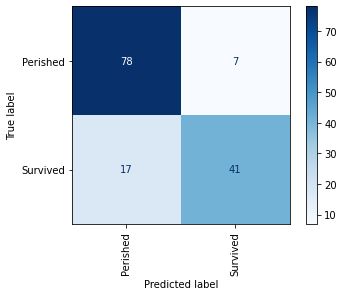

In [7]:
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
 
plot_confusion_matrix(model, x_test, y_test, display_labels=['Perished', 'Survived'], cmap='Blues', xticks_rotation='vertical')

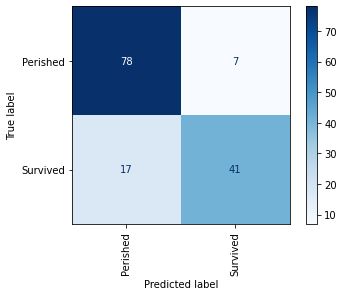

In [15]:
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay as cmd

cmd.from_estimator(model, x_test, y_test, display_labels=['Perished', 'Survived'], cmap='Blues', xticks_rotation='vertical')

In [16]:
female = [[30, 1, 0, 1, 0, 0]]
model.predict(female)[0]

c:\users\jeffp\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


1

In [18]:
female = pd.DataFrame({ 'Age': [30], 'Sex_female': [1], 'Sex_male': [0],
                        'Pclass_1': [1], 'Pclass_2': [0], 'Pclass_3': [0] })

model.predict(female)[0]

1

In [19]:
probability = model.predict_proba(female)[0][1]
print(f'Probability of survival: {probability:.1%}')

Probability of survival: 91.6%


In [21]:
male = pd.DataFrame({ 'Age': [60], 'Sex_female': [0], 'Sex_male': [1],
                      'Pclass_1': [0], 'Pclass_2': [0], 'Pclass_3': [1] })

probability = model.predict_proba(male)[0][1]
print(f'Probability of survival: {probability:.1%}')

Probability of survival: 2.9%


In [25]:
from sklearn.metrics import precision_score, recall_score

y_pred = model.predict(x_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
sensitivity = recall
specificity = recall_score(y_test, y_pred, pos_label=0)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

Precision: 0.8541666666666666
Recall: 0.7068965517241379
Sensitivity: 0.7068965517241379
Specificity: 0.9176470588235294


In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
 
data = [[10, 'red'], [20, 'blue'], [12, 'red'], [16, 'green'], [22, 'blue']]
df = pd.DataFrame(data, columns=['Length', 'Color'])
 
encoder = LabelEncoder()
df['Color'] = encoder.fit_transform(df['Color'])
df.head()

,Length,Color
0,10,2
1,20,0
2,12,2
3,16,1
4,22,0


In [2]:
encoder.classes_

array(['blue', 'green', 'red'], dtype=object)